In [1]:
from PipelineResources import * # This is where we have all of the resources that will be used in the project. 

The problem occurs because either compilation failed when you installed Somoclu or a path is missing from the dependencies when you are trying to import it. Please refer to the documentation to see your options.


In [2]:
nasdaq = pd.read_pickle('nasdaq_qqq_yahoo.pckl')

## Prepare training, validation and test sets

### First Test: Use a CNN Model to predict whether or not the next day will close above 1.5 %. 
The goal behind this exercise is to establish a baseline model and performance. In addition, it is also work out the way the data will be stored. 

In [3]:
number_of_samples = nasdaq.index.size
print(" Sample size is: {}".format(number_of_samples))

 Sample size is: 4780


In [4]:
nasdaq.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'open_change', 'open_change_pct', 'next_day_open_change',
       'next_day_open_change_pct', 'open_change_wrt_close',
       'open_change_wrt_close_pct', 'open_change_wrt_high',
       'open_change_wrt_low', 'open_change_wrt_volume',
       'next_day_open_change_wrt_close', 'next_day_open_change_wrt_close_pct',
       'next_day_open_change_wrt_high', 'next_day_open_change_wrt_low',
       'next_day_open_change_wrt_volume', 'close_change_pct', 'close_change',
       'high_change_pct', 'high_change', 'low_change_pct', 'low_change',
       'volume_change_pct', 'volume_change', 'high_low_range',
       'high_low_range_with_ref_open', 'high_low_range_with_ref_open_pct',
       'high_low_range_with_ref_close', 'high_low_range_with_ref_close_pct',
       'gt_1', 'gt_1.5', 'gt_2.5'],
      dtype='object')

In [5]:
random_state = 1
x_train, x_val, x_test, y_train, y_val, y_test = get_input_sets(nasdaq, chosen_features, chosen_label, x_test=False,
                                                               number_of_days_per_sample=1)
print(x_train.shape)


number of days per samples: 1
(4776,)
[0 1 0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0]
[0 0 0 1 1 0 0 1 0 0 0 0 0 0 0 0 0 0 1 1]
(4776, 13)
(3582, 13)


In [6]:
x_val, y_val = decrease_class_rows(x_val, y_val, class_number=0, percentage_cut=0.90)
x_train, y_train = decrease_class_rows(x_train, y_train, class_number=0, percentage_cut=0.90)


1130
1017
(177,)
(177, 13)
3400
3060
(522,)
(522, 13)


In [7]:
x_train, x_val, x_test = modify_dataset_channels(x_train, x_val, x_test=False, compute_fft=True, multi_channel=True)

(522, 2, 13)
(177, 2, 13)


In [8]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        """
        Args:
          in_channels (int):  Number of input channels.
          out_channels (int): Number of output channels.
          stride (int):       Controls the stride.
        """
        super(Block, self).__init__()
        kernel_size_0 = 3
        padding_0 = 1
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.conv1d_0 = nn.Conv1d(in_channels=in_channels, 
                                  out_channels=out_channels, 
                                 kernel_size=kernel_size_0,
                                 stride=stride,
                                 padding=padding_0,
                                 bias=False)
        self.conv1d_0 = self.conv1d_0.to(device)
        self.conv1d_1 = nn.Conv1d(in_channels=out_channels, 
                                  out_channels=out_channels, 
                                 kernel_size=kernel_size_0,
                                 stride=1,
                                 padding=padding_0,
                                 bias=False)
        self.conv1d_1 = self.conv1d_1.to(device)
        self.relu = nn.ReLU()
        self.batch_0_0 = nn.BatchNorm1d(out_channels)
        self.batch_0_0 = self.batch_0_0.to(device)
        self.batch_0_1 = nn.BatchNorm1d(out_channels)
        self.batch_0_1 = self.batch_0_1.to(device)
        padding_1 = 0
        stride_1 =1
        kernel_size_1 = 1
        self.skip_layer_1 = nn.Conv1d(in_channels, out_channels, 
                                 kernel_size=kernel_size_1,
                                 stride=stride,
                                 padding=padding_1,
                                 bias=False)
        self.skip_layer_1 = self.skip_layer_1.to(device)
        

    def forward(self, x):
        # bp()
        x = x.float()
        x_skip = x.clone()
        x = x.to(device)
        x_skip = x_skip.to(device)
        initial_shape = x.shape
        x = self.relu(self.batch_0_0(self.conv1d_0(x)))
        x = self.batch_0_1(self.conv1d_1(x))
        current_shape = x.shape
        if np.alltrue(current_shape == initial_shape):
            y = x_skip + x
        else:
            x_skip = self.batch_0_1(self.skip_layer_1(x_skip))
            y = x_skip + x
        y =  self.relu(y)
        return y

In [9]:
# Let us implement a group of blocks in this cell
class GroupOfBlocks(nn.Module):
    def __init__(self, in_channels, out_channels, n_blocks, stride=1):
        super(GroupOfBlocks, self).__init__()

        first_block = Block(in_channels, out_channels, stride)
        other_blocks = [Block(out_channels, out_channels) for _ in range(1, n_blocks)]
        self.group = nn.Sequential(first_block, *other_blocks)

    def forward(self, x):
        return self.group(x)

In [10]:
# Let's test it
device = torch.device('cuda:0')
group = GroupOfBlocks(in_channels=10, out_channels=20, n_blocks=3)
print(group)

GroupOfBlocks(
  (group): Sequential(
    (0): Block(
      (conv1d_0): Conv1d(10, 20, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (conv1d_1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (relu): ReLU()
      (batch_0_0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_0_1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_layer_1): Conv1d(10, 20, kernel_size=(1,), stride=(1,), bias=False)
    )
    (1): Block(
      (conv1d_0): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (conv1d_1): Conv1d(20, 20, kernel_size=(3,), stride=(1,), padding=(1,), bias=False)
      (relu): ReLU()
      (batch_0_0): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (batch_0_1): BatchNorm1d(20, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (skip_layer_1): Conv1d(20, 20, kernel_si

In [11]:
class ResNet(nn.Module):
    def __init__(self, n_blocks,in_channels=1, n_channels=64, num_classes=2):
        """
        Args:
          n_blocks (list):   A list with three elements which contains the number of blocks in 
                             each of the three groups of blocks in ResNet.
                             For instance, n_blocks = [2, 4, 6] means that the first group has two blocks,
                             the second group has four blocks and the third one has six blocks.
          n_channels (int):  Number of channels in the first group of blocks.
          num_classes (int): Number of classes.
        """
        assert len(n_blocks) == 3, "The number of groups should be three."
        super(ResNet, self).__init__()
        self.name = 'ResNet'
        self.conv1 = nn.Conv1d(in_channels=in_channels, out_channels=n_channels, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm1d(n_channels)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool1d(kernel_size=3, stride=2, padding=1)

        groups = []
        """
        for index, block in enumerate(n_blocks):
            factor = index
            groups.append(GroupOfBlocks(in_channels=2**(factor) * n_channels, 
                                              out_channels=2**(factor + 1) * n_channels,
                                             n_blocks=block))
        bp()
        self.groups = nn.Sequential(*groups)
        """
        self.group_0 = GroupOfBlocks(in_channels=n_channels, 
                                              out_channels=2 * n_channels,
                                             n_blocks=n_blocks[0])
        self.group_1 = GroupOfBlocks(in_channels=2 * n_channels, 
                                              out_channels=4 * n_channels,
                                             n_blocks=n_blocks[1],
                                    stride=2)
        self.group_2 = GroupOfBlocks(in_channels=4 *  n_channels, 
                                              out_channels=4 * n_channels,
                                             n_blocks=n_blocks[2],
                                    stride=2)
        self.avgpool = nn.AvgPool1d(kernel_size=2, stride=1)
        self.fc = nn.Linear(4*n_channels, num_classes)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, nn.Conv1d):
                n = m.kernel_size[0] * m.out_channels
                m.weight.data.normal_(0, np.sqrt(2. / n))
            elif isinstance(m, nn.BatchNorm1d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def forward(self, x, verbose=False):
        x = x.float()
        if verbose: print(x.shape)
        #bp()
        x = self.conv1(x)
        if verbose: print('conv1:  ', x.shape)
        x = self.bn1(x)
        if verbose: print('bn1:    ', x.shape)
        x = self.relu(x)
        if verbose: print('relu:   ', x.shape)
        x = self.maxpool(x)
        if verbose: print('maxpool:', x.shape)
        #bp()
        # x = self.groups(x)
        x = self.group_0(x)
        x = self.group_1(x)
        x = self.group_2(x)
        #bp()
        x = self.avgpool(x)
        if verbose: print('avgpool:', x.shape)

        x = x.view(-1, self.fc.in_features)
        #x = x.view(h, self.fc.in_features * w)
        if verbose: print('x.view: ', x.shape)
        x = self.fc(x)
        if verbose: print('out:    ', x.shape)

        return x

In [12]:
# Create a network with 2 block in each of the three groups
n_blocks = [2, 2, 2]  # number of blocks in the three groups

net = ResNet(n_blocks, in_channels=x_train.shape[1], n_channels=10)
net.to(device)
criterion = nn.CrossEntropyLoss()

with torch.no_grad():
    #bp()
    input_data = torch.tensor(x_train).float()
    labels = torch.tensor(y_train).long()
    input_data = input_data.to(device)
    labels = labels.to(device)
    print('Shape of the input tensor:', input_data.shape)
    y = net.forward(input_data, verbose=True)
    loss = criterion(y, labels)
    print('loss: {}'.format(loss))
    assert y.shape == torch.Size([y_train.shape[0], 2]), "Bad shape of y: y.shape={}".format(y.shape)

print('The shapes seem to be ok.')


Shape of the input tensor: torch.Size([522, 2, 13])
torch.Size([522, 2, 13])
conv1:   torch.Size([522, 10, 13])
bn1:     torch.Size([522, 10, 13])
relu:    torch.Size([522, 10, 13])
maxpool: torch.Size([522, 10, 7])
avgpool: torch.Size([522, 40, 1])
x.view:  torch.Size([522, 40])
out:     torch.Size([522, 2])
loss: 0.7010028958320618
The shapes seem to be ok.


  epoch    f1_train    f1_val    train_loss    valid_acc    valid_loss     dur
-------  ----------  --------  ------------  -----------  ------------  ------
      1      0.3478    0.5211        1.0537       0.3524       25.3374  0.0843
      2      0.4299    0.3404        1.0198       0.7048        0.9920  0.0864
      3      0.3316    0.0000        0.7134       0.6476        0.8122  0.0861
      4      0.2842    0.3404        0.6562       0.7048        0.5983  0.0835
      5      0.4664    0.0526        0.6236       0.6571        0.6648  0.0819


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6      0.3981    0.3404        0.5903       0.7048        0.6189  0.0893
      7      0.5083    0.3404        0.5933       0.7048        0.6274  0.0878
      8      0.4602    0.3750        0.5837       0.7143        0.6051  0.0804
      9      0.4783    0.3750        0.5924       0.7143        0.5945  0.0880
     10      0.4716    0.4231        0.5775       0.7143        0.5851  0.0801
     11      0.4936    0.4231        0.5886       0.7143        0.5890  0.0839
     12      0.4649    0.4528        0.5747       0.7238        0.5831  0.0870
     13      0.4766    0.4528        0.5877       0.7238        0.5837  0.0917
     14      0.4762    0.4528        0.5703       0.7238        0.5887  0.0866
     15      0.4851    0.4528        0.5842       0.7238        0.5969  0.0851
     16      0.4696    0.4528        0.5653       0.7238        0.6066  0.1417
     17      0.5126    0.4528        0.5755       0.7238        0.6190  0.1092
     18      0.4848    0.4444        0.5513       0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     33      0.7105    0.4946        0.4381       0.5524        0.6732  0.1049
     34      0.6945    0.6667        0.4583       0.7429        0.5677  0.1206
     35      0.6765    0.5000        0.4532       0.6381        0.7028  0.1221
     36      0.7386    0.7045        0.4255       0.7524        0.5390  0.1090
     37      0.7157    0.4673        0.4343       0.4571        0.7631  0.0932
     38      0.5370    0.6173        0.5332       0.7048        0.5365  0.0909
     39      0.6090    0.1026        0.5066       0.6667        0.6954  0.0940
     40      0.6444    0.1500        0.4633       0.6762        1.2805  0.1163
     41      0.6899    0.0526        0.4520       0.6571        0.7696  0.1082
     42      0.7099    0.6885        0.4359       0.8190        0.5170  0.0987
     43      0.7279    0.6835        0.4201       0.7619        0.5794  0.0830
     44      0.6758    0.5938        0.4417       0.7524        0.5950  0.0925
     45      0.7582    0.6355        0.3998       0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     56      0.7754    0.5455        0.3632       0.7619        0.7124  0.0814
     57      0.6692    0.4906        0.3742       0.7429        0.8825  0.0890
     58      0.7877    0.4314        0.3407       0.7238        1.0822  0.0977
     59      0.7619    0.6769        0.3378       0.8000        0.7876  0.1435
     60      0.7448    0.4800        0.4004       0.7524        0.9613  0.1449
     61      0.7042    0.0526        0.4329       0.6571        1.0757  0.0864
     62      0.6824    0.6667        0.4495       0.7524        0.6722  0.0958
     63      0.7235    0.6333        0.4364       0.7905        0.5704  0.1247
     64      0.7153    0.7250        0.3861       0.7905        0.5771  0.1363
     65      0.7460    0.2667        0.3879       0.6857        0.8073  0.0864
     66      0.7011    0.5614        0.3983       0.7619        0.7135  0.0905
     67      0.7640    0.4490        0.4391       0.7429        0.8931  0.1331
     68      0.7234    0.4615        0.3706       0.

<Figure size 432x288 with 0 Axes>

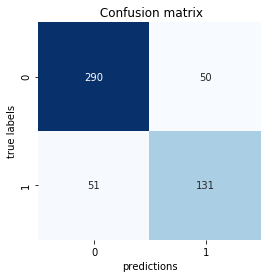

<Figure size 432x288 with 0 Axes>

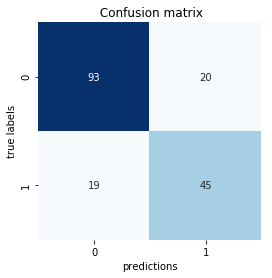

In [41]:
model = None
model_name = ResNet.__name__
noise_training = False
#n_channels = x_train.shape[1]
#n_features = x_train.shape[2]
device = torch.device('cuda:0')
accuracy_epoch_scoring_val = EpochScoring(scoring='f1',name='f1_val', lower_is_better=False, on_train=False)
accuracy_epoch_scoring_train = EpochScoring(scoring='f1',name='f1_train', lower_is_better=False, on_train=True)
n_blocks = [2, 2, 2]  # number of blocks in the three groups
in_channels=x_train.shape[1]
n_channels = 64
n_epochs = 70
model = NeuralNetClassifier(module=ResNet, criterion=nn.CrossEntropyLoss,
                          module__n_channels= n_channels,
                          module__n_blocks=n_blocks,
                          module__in_channels=in_channels,
                          optimizer=optim.Adam, 
                          optimizer__lr=0.01,
                          #optimizer__weight_decay=0.01,
                          max_epochs=n_epochs, 
                          batch_size=100,
                          iterator_train__shuffle=False,
                          device=device,
                          warm_start=True,#train_split=None,
                          callbacks=[accuracy_epoch_scoring_val, accuracy_epoch_scoring_train],
                         )
if noise_training:
    noise_rounds = 10
    for _ in range(noise_rounds):
        x_noise = add_noise(x_train, noise_distribution=np.random.rayleigh, std=np.random.uniform(0,0.5))
        #x_noise = add_noise(x)
        model.partial_fit(x_noise, y_train)
else:
    model.fit(x_train, y_train)

pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_train, prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)    

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information='ResNet',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)




Accuracy of Net: 0.81

Classification report:
             precision    recall  f1-score   support

          0       0.85      0.85      0.85       340
          1       0.72      0.72      0.72       182

avg / total       0.81      0.81      0.81       522

Accuracy of Net: 0.78

Classification report:
             precision    recall  f1-score   support

          0       0.83      0.82      0.83       113
          1       0.69      0.70      0.70        64

avg / total       0.78      0.78      0.78       177



<Figure size 432x288 with 0 Axes>

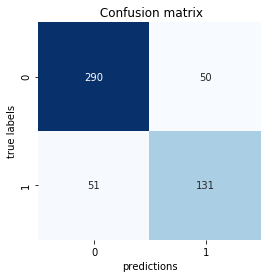

<Figure size 432x288 with 0 Axes>

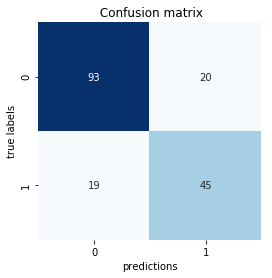

In [43]:
pred_test = model.predict(x_train)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_train, prefix_information=model_name,
                          dataset_name='train', save_results=False,
                     y_pred_is_predicted_classes=True)    

plt.savefig(fname='latex/figures/' + 'ResNet_Training_results' + '.pdf', format='pdf', dpi=300)

pred_test = model.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information='ResNet',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)
plt.savefig(fname='latex/figures/' + 'ResNet_Test_results' + '.pdf', format='pdf', dpi=300)

### Hyper Parameter Optimization

In [61]:
M = 20
optimizer__lr= np.random.uniform(2e-2, 1e-3, M)
weight_decay = np.random.uniform(1e-2,0.3 , M)
optimizer__weight_decay = np.random.uniform(1e-2,0.3 , M)
max_epochs = np.random.randint(2, 100, M)
n_blocks = [np.random.randint(2, 10, size=3) for _ in range(M)]
batch_size = [4, 10, 20, 50, 100, 200]
optimizers = (optim.SGD, optim.Adam)
parameters = {#'optimizer__lr': optimizer__lr, 
    #'optimizer': optimizers, 
    #'optimizer__weight_decay': optimizer__weight_decay,
    #'max_epochs': max_epochs
    'module__n_blocks': n_blocks,
}
print(parameters)

{'module__n_blocks': [array([7, 2, 9]), array([5, 5, 7]), array([8, 5, 2]), array([5, 9, 5]), array([9, 6, 5]), array([5, 9, 8]), array([5, 7, 3]), array([2, 8, 3]), array([2, 2, 9]), array([3, 2, 4]), array([8, 9, 7]), array([9, 4, 7]), array([2, 8, 3]), array([7, 8, 5]), array([8, 8, 5]), array([3, 4, 7]), array([9, 3, 3]), array([7, 9, 7]), array([6, 4, 5]), array([7, 3, 4])]}


  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0650        0.5779       0.7850        0.5140  0.6612
      2  0.0650        0.5504       0.7850        0.5068  0.6258
      3  0.0000        0.5318       0.7794        0.5183  0.6157


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.5108       0.7794        0.5083  0.6184


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5144       0.7794        0.5134  0.6243


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5117       0.7794        0.5114  0.6202


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5118       0.7794        0.5141  0.6219


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.5069       0.7794        0.5092  0.6203


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.5046       0.7794        0.5081  0.6214


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.5044       0.7794        0.5052  0.6251


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.5005       0.7794        0.5014  0.6190


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4948       0.7794        0.5115  0.6201


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.5007       0.7794        0.5027  0.6241


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     14  0.0000        0.4977       0.7794        0.4962  0.6193


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0000        0.4947       0.7794        0.4950  0.6193


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     16  0.3396        0.4830       0.7383        0.5268  0.6213
     17  0.0800        0.4872       0.7850        0.4910  0.6177
     18  0.4583        0.4792       0.7570        0.5182  0.6163
     19  0.0000        0.4646       0.7794        0.4867  0.6151


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     20  0.4059        0.4812       0.7757        0.4834  0.6249
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0513        0.5838       0.7925        0.5173  0.6153
      2  0.0661        0.5052       0.7888        0.5059  0.6190
      3  0.2113        0.5000       0.7907        0.5127  0.6193
      4  0.2368        0.4975       0.7832        0.5195  0.6191
      5  0.2692        0.4958       0.7869        0.5243  0.6182
      6  0.2500        0.4938       0.7869        0.5194  0.6177
      7  0.2675        0.4932       0.7850        0.5241  0.6193
      8  0.2692        0.4900       0.7869        0.5135  0.7101
      9  0.2675        0.4855       0.7850        0.5171  0.7245
     10  0.0504        0.4957       0.7888        0.5082  0.6750
     11  0.0000        0.4916       0.7888        0.4960  0.7171


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.1940        0.4828       0.7981        0.4836  0.7438
     13  0.0826        0.4947       0.7925        0.5122  0.6333
     14  0.0000        0.4780       0.7888        0.5301  0.7312


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.3886        0.4830       0.8000        0.4911  0.7143
     16  0.2877        0.4621       0.8056        0.4779  0.7116
     17  0.2714        0.4614       0.8093        0.4654  0.6419
     18  0.4022        0.4526       0.8000        0.4670  0.7504
     19  0.0968        0.4586       0.7907        0.4774  0.6275
     20  0.0833        0.4426       0.7944        0.4588  0.6222
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0678        0.6014       0.7944        0.5163  0.6319
      2  0.0000        0.5097       0.7925        0.5103  0.7586


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5142       0.7925        0.4980  0.6448


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.4963       0.7925        0.4974  0.6870


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4955       0.7925        0.4988  0.6236


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.4913       0.7925        0.4954  0.6213


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4860       0.7925        0.4966  0.6221


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4836       0.7925        0.4948  0.6279


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4792       0.7925        0.4827  0.6309


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4812       0.7925        0.4857  0.6997


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4812       0.7925        0.4935  0.6818


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4626       0.7925        0.4986  0.6763


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0351        0.4606       0.7944        0.4776  0.6519
     14  0.0351        0.4464       0.7944        0.4898  0.7056
     15  0.0522        0.4382       0.7963        0.4970  0.6985
     16  0.0000        0.4333       0.7925        0.5692  0.6585


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.1587        0.4257       0.8019        0.4411  0.6330
     18  0.0351        0.4172       0.7944        0.4981  0.6324
     19  0.4114        0.4198       0.8075        0.5208  0.6353
     20  0.0522        0.4101       0.7963        0.5210  0.7336
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0656        0.6101       0.7869        0.5348  0.5521
      2  0.1765        0.5629       0.7907        0.5046  0.6015
      3  0.0000        0.5424       0.7794        0.5157  0.5833


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.5237       0.7794        0.5117  0.6120


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5163       0.7794        0.5059  0.6596


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5140       0.7794        0.5088  0.6438


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5111       0.7794        0.5052  0.5702


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.5077       0.7794        0.5146  0.6188


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0168        0.4928       0.7813        0.4888  0.6275
     10  0.0640        0.4927       0.7813        0.5035  0.5926
     11  0.0000        0.4889       0.7794        0.5229  0.5998


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.3878        0.4710       0.7757        0.5202  0.6159
     13  0.2517        0.4662       0.7888        0.5232  0.5548
     14  0.0960        0.4495       0.7888        0.4701  0.5911
     15  0.3291        0.4322       0.8019        0.4399  0.5599
     16  0.4486        0.4216       0.7794        0.5680  0.5729
     17  0.3208        0.4309       0.2243        0.8967  0.5824
     18  0.3622        0.4049       0.2299        0.9943  0.5814
     19  0.3617        0.4014       0.2280        1.1590  0.5955
     20  0.4444        0.3957       0.8037        0.5030  0.5950
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0667        0.5990       0.7907        0.5107  0.6020
      2  0.2113        0.5129       0.7907        0.5307  0.6070
      3  0.2857        0.5031       0.7757        0.5659  0.6131
      4  0.2840        0.4988       0.7738        0.5531  0.6012
      5  0.2824        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0000        0.5179       0.7925        0.5285  0.6298


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5183       0.7925        0.5037  0.5644


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.4977       0.7925        0.5125  0.5594


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4937       0.7925        0.5116  0.5578


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.4930       0.7925        0.5075  0.5562


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4896       0.7925        0.5092  0.5566


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4841       0.7925        0.5115  0.5598


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4806       0.7925        0.5014  0.5611


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4799       0.7925        0.5056  0.5623


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4710       0.7925        0.4902  0.5654


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4665       0.7925        0.4999  0.5620


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4609       0.7925        0.5117  0.5630


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     14  0.0000        0.4498       0.7925        0.4874  0.5601


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0678        0.4437       0.7944        0.5224  0.5625
     16  0.0690        0.4440       0.7981        0.4614  0.5623
     17  0.1538        0.4257       0.7944        0.5286  0.5566
     18  0.0847        0.4222       0.7981        0.4625  0.5512
     19  0.2105        0.4144       0.8037        0.4934  0.5520
     20  0.0177        0.4130       0.7925        0.5489  0.5562
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.5798       0.7794        0.5441  0.6098


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0000        0.5276       0.7794        0.5128  0.6210


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0168        0.5064       0.7813        0.5020  0.6144
      4  0.0000        0.5081       0.7794        0.5046  0.6107


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5065       0.7794        0.5043  0.6133


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0168        0.5042       0.7813        0.5006  0.6141
      7  0.0333        0.5021       0.7832        0.5009  0.6164
      8  0.0333        0.4972       0.7832        0.4982  0.6126
      9  0.0492        0.4915       0.7832        0.4836  0.6179
     10  0.1642        0.4812       0.7907        0.4546  0.6279
     11  0.2429        0.4729       0.8019        0.4496  0.6200
     12  0.3981        0.4418       0.7626        0.5172  0.6315
     13  0.1805        0.4391       0.7963        0.4530  0.6369
     14  0.4412        0.4235       0.7869        0.4764  0.6344
     15  0.4809        0.4258       0.7458        0.5103  0.6273
     16  0.3846        0.4232       0.7607        0.5227  0.6344
     17  0.4683        0.4117       0.7963        0.4476  0.7251
     18  0.4096        0.3910       0.8168        0.4433  0.6545
     19  0.4508        0.3939       0.6037        0.6778  0.7172
     20  0.4600        0.4147       0.5963        0.6693  0.6282
  epoch      f1    train_

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.4982       0.7888        0.5130  0.7924


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.1270        0.4967       0.7944        0.5145  0.6460
      8  0.0000        0.4952       0.7888        0.5090  0.6271


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0345        0.4883       0.7907        0.4919  0.6237
     10  0.0000        0.4928       0.7888        0.4927  0.6332


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.2353        0.4702       0.8056        0.5122  0.6737
     12  0.1515        0.4708       0.7907        0.4660  0.6461
     13  0.0508        0.4811       0.7907        0.4773  0.6478
     14  0.4216        0.4626       0.7794        0.5452  0.6222
     15  0.0000        0.4585       0.7888        0.5577  0.6160


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     16  0.3583        0.4403       0.7121        0.5827  0.6494
     17  0.0508        0.4327       0.7907        0.5472  0.6389
     18  0.2963        0.4794       0.7869        0.5131  0.7235
     19  0.0174        0.4409       0.7888        0.5519  0.6936
     20  0.4082        0.4309       0.4579        0.9785  0.6348
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.5572       0.7925        0.5112  0.6153


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0000        0.5104       0.7925        0.5104  0.6174


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5015       0.7925        0.5047  0.6230


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.4925       0.7925        0.5136  0.6736


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4911       0.7925        0.5089  0.6245


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.4878       0.7925        0.5100  0.6138


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4849       0.7925        0.5010  0.6568


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4817       0.7925        0.5000  0.7973


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4771       0.7925        0.5043  0.6354


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4781       0.7925        0.4922  0.7116


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4746       0.7925        0.4984  0.6590


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4689       0.7925        0.5139  0.6265


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4525       0.7925        0.5167  0.7583


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     14  0.0000        0.4534       0.7925        0.5365  0.6754


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0000        0.4449       0.7925        0.5031  0.6721


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     16  0.0678        0.4366       0.7944        0.5077  0.6199
     17  0.0000        0.4505       0.7925        0.5511  0.6273


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     18  0.0522        0.4306       0.7963        0.4549  0.6122
     19  0.0000        0.4204       0.7907        0.5581  0.6134
     20  0.0177        0.4155       0.7925        0.5237  0.6091
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.5959       0.7794        0.5324  0.7887


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0000        0.5294       0.7794        0.5071  0.8002


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5151       0.7794        0.5059  0.7964


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.5100       0.7794        0.5036  0.8016


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5084       0.7794        0.5029  0.7823


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0168        0.5063       0.7813        0.5037  0.7949
      7  0.0168        0.5050       0.7813        0.5042  0.7606
      8  0.0496        0.5024       0.7850        0.5061  0.7413
      9  0.0167        0.4971       0.7794        0.5055  0.7365
     10  0.1094        0.4921       0.7869        0.4916  0.7367
     11  0.0960        0.4842       0.7888        0.4730  0.7330
     12  0.2254        0.4758       0.7944        0.5077  0.7378
     13  0.1240        0.5026       0.7888        0.4936  0.7410
     14  0.0640        0.4958       0.7813        0.4896  0.7371
     15  0.4248        0.4652       0.6355        0.5773  0.7419
     16  0.4312        0.4563       0.7682        0.5430  0.7412
     17  0.4531        0.4536       0.7383        0.5159  0.7452
     18  0.4581        0.4503       0.7701        0.5333  0.7387
     19  0.2778        0.4381       0.8056        0.4494  0.7586
     20  0.4855        0.4251       0.7346        0.5739  0.7492
  epoch      f1    train_

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0667        0.4980       0.7907        0.5048  0.7354
      4  0.0661        0.4961       0.7888        0.5084  0.7415
      5  0.0813        0.4941       0.7888        0.5090  0.7359
      6  0.0661        0.4923       0.7888        0.5034  0.8289
      7  0.1270        0.4900       0.7944        0.5026  0.8226
      8  0.1705        0.4858       0.8000        0.5153  0.8749
      9  0.0513        0.4754       0.7925        0.4997  0.8253
     10  0.3519        0.4768       0.6075        0.6359  0.8252
     11  0.2194        0.4588       0.7738        0.5252  0.8186
     12  0.2710        0.4632       0.7888        0.5168  0.8260
     13  0.2789        0.4711       0.6037        0.6239  0.8202
     14  0.3498        0.4475       0.3121        1.1063  0.8241
     15  0.1120        0.4258       0.7925        0.4662  0.8605
     16  0.3364        0.4372       0.5944        0.6906  0.8217
     17  0.2913        0.4357       0.3271        0.9657  0.8969
     18  0.3779        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0000        0.5111       0.7925        0.5190  0.8246


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5147       0.7925        0.5052  0.8268


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.4970       0.7925        0.5096  0.8215


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4966       0.7925        0.5141  0.8475


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.4903       0.7925        0.5079  0.8335


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4866       0.7925        0.5263  0.8752


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4846       0.7925        0.5018  0.8710


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4792       0.7925        0.5210  0.8600


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4725       0.7925        0.5211  0.8493


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4720       0.7925        0.4819  0.8501


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4544       0.7925        0.4841  0.8787


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4504       0.7925        0.5102  0.8385


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     14  0.2603        0.4422       0.7981        0.5011  0.8656
     15  0.1167        0.4447       0.8019        0.5086  0.8447
     16  0.2911        0.4495       0.7907        0.5037  0.8276
     17  0.3352        0.4304       0.5551        0.6865  0.8235
     18  0.0000        0.4308       0.7907        0.5470  0.8462
     19  0.4495        0.4231       0.6841        0.5782  0.8723
     20  0.3503        0.4276       0.5701        0.6698  0.8113
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.7921       0.7794        0.5434  0.9272


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0640        0.5534       0.7813        0.5039  0.9306
      3  0.1515        0.5370       0.7907        0.4993  0.9244
      4  0.0496        0.5307       0.7850        0.5038  0.9298
      5  0.0000        0.5253       0.7794        0.5126  0.9250


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5199       0.7794        0.5180  0.9308


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5133       0.7794        0.5165  0.9212


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.5100       0.7794        0.5207  0.9359


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.5030       0.7794        0.5134  0.9407


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4964       0.7794        0.5322  0.9219


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0168        0.4956       0.7813        0.5107  0.9725
     12  0.0000        0.5030       0.7794        0.5151  0.9185


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.3585        0.4743       0.7458        0.5556  0.9274
     14  0.1240        0.4729       0.7888        0.4915  0.9277
     15  0.0000        0.4619       0.7794        0.5489  0.9254


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     16  0.0496        0.4662       0.7850        0.4669  0.9265
     17  0.0000        0.4506       0.7794        0.5998  0.9919


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     18  0.0000        0.4432       0.7794        0.6187  1.0460


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     19  0.0656        0.4329       0.7869        0.5147  1.0794
     20  0.0000        0.4273       0.7794        0.8284  1.0221


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0661        0.6539       0.7888        0.5101  1.0219
      2  0.0813        0.5283       0.7888        0.5214  1.0210
      3  0.2581        0.5112       0.7850        0.5553  1.0073
      4  0.2767        0.5038       0.7850        0.5543  1.0103
      5  0.2785        0.5003       0.7869        0.5568  1.0124
      6  0.2767        0.4986       0.7850        0.5532  1.0064
      7  0.2500        0.4974       0.7869        0.5328  1.0072
      8  0.2468        0.4971       0.7832        0.5161  1.0219
      9  0.2313        0.4865       0.7888        0.5135  1.0161
     10  0.2945        0.4782       0.7850        0.5427  1.0219
     11  0.2029        0.4691       0.7944        0.5068  1.0179
     12  0.3627        0.4704       0.7701        0.5551  1.0243
     13  0.2270        0.4685       0.7963        0.5138  1.0208
     14  0.3441        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5208       0.7925        0.5377  1.0510


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.5163       0.7925        0.5053  1.0784


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.4985       0.7925        0.5101  1.0025


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.4927       0.7925        0.5041  1.0015


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4887       0.7925        0.5017  0.9249


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4847       0.7925        0.5046  0.9262


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4800       0.7925        0.5000  0.9339


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4724       0.7925        0.4965  0.9362


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4649       0.7925        0.4811  0.9218


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4575       0.7925        0.5281  0.9296


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0000        0.4505       0.7925        0.5457  0.9255


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     14  0.0351        0.4500       0.7944        0.4812  0.9207
     15  0.0000        0.4328       0.7907        0.5833  0.9534
     16  0.0000        0.4302       0.7925        0.5845  0.9480


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.2721        0.4198       0.8000        0.4807  1.0021
     18  0.0826        0.4174       0.7925        0.5233  0.9725
     19  0.0000        0.4079       0.7925        0.5916  0.9899


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     20  0.0517        0.4221       0.7944        0.5215  1.0015
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.8756       0.7794        0.5344  1.0750


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0650        0.5418       0.7850        0.5027  1.0799
      3  0.1765        0.5262       0.7907        0.4994  1.0774
      4  0.1752        0.5220       0.7888        0.4996  1.0861
      5  0.1884        0.5197       0.7907        0.4994  1.0821
      6  0.2014        0.5181       0.7925        0.5003  1.0778
      7  0.1752        0.5161       0.7888        0.5009  1.0849
      8  0.2014        0.5143       0.7925        0.5005  1.0825
      9  0.2649        0.5122       0.7925        0.5063  1.0781
     10  0.2361        0.5062       0.7944        0.4978  1.0790
     11  0.2683        0.4967       0.7757        0.5176  1.0823
     12  0.0650        0.5082       0.7850        0.5035  1.0855
     13  0.0640        0.5126       0.7813        0.4907  1.0795
     14  0.0000        0.4818       0.7794        0.5083  1.0765


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.3464        0.4627       0.7813        0.4960  1.0820
     16  0.4598        0.4630       0.7364        0.5381  1.0852
     17  0.0333        0.4543       0.7832        0.5675  1.0914
     18  0.0938        0.4400       0.7832        0.4927  1.0842
     19  0.4242        0.4408       0.6093        0.7471  1.0816
     20  0.0496        0.4387       0.7850        0.5147  1.1093
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0667        0.7317       0.7907        0.5378  1.0821
      2  0.0661        0.5600       0.7888        0.5103  1.1183
      3  0.2581        0.5200       0.7850        0.5319  1.0835
      4  0.2581        0.5031       0.7850        0.5370  1.0803
      5  0.2692        0.4989       0.7869        0.5509  1.0801
      6  0.2581        0.4967       0.7850        0.5523  1.0797
      7  0.2675        0.4966       0.7850        0.5639  1.0821
      8  0.2581        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5454       0.7925        0.5617  1.2454


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0984        0.5644       0.7944        0.4937  1.2426
      5  0.0840        0.5100       0.7963        0.4992  1.2443
      6  0.0000        0.4977       0.7925        0.5272  1.2155


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5092       0.7925        0.5558  1.2186


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.5049       0.7925        0.5226  1.2026


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0342        0.4951       0.7888        0.5378  1.2314
     10  0.0000        0.4890       0.7925        0.5164  1.2056


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0351        0.4934       0.7944        0.5074  1.2334
     12  0.0177        0.4894       0.7925        0.5402  1.2334
     13  0.0351        0.4847       0.7944        0.5163  1.2254
     14  0.0000        0.4647       0.7907        0.4981  1.2570
     15  0.0000        0.4654       0.7925        0.5290  1.1361


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     16  0.1985        0.4553       0.8037        0.5144  1.0880
     17  0.4332        0.4580       0.7701        0.4957  1.0877
     18  0.0000        0.4449       0.7925        0.5948  1.1160


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     19  0.3553        0.4482       0.8168        0.5193  1.1119
     20  0.0351        0.4366       0.7944        0.5610  1.0872
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.7534       0.7794        0.5198  1.2534


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0650        0.5289       0.7850        0.5063  1.2982
      3  0.1385        0.5256       0.7907        0.4997  1.3206
      4  0.0496        0.5318       0.7850        0.5031  1.2886
      5  0.0000        0.5381       0.7794        0.5317  1.2324


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5178       0.7794        0.5111  1.2357


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5278       0.7794        0.5317  1.2396


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0333        0.5017       0.7832        0.5013  1.2449
      9  0.0000        0.5110       0.7794        0.5347  1.2461


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0896        0.5085       0.7720        0.5272  1.2388
     11  0.0168        0.4933       0.7813        0.5231  1.2826
     12  0.3163        0.4883       0.7252        0.5407  1.2739
     13  0.0496        0.4807       0.7850        0.5301  1.2855
     14  0.0000        0.5094       0.7794        0.5028  1.2375


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     15  0.0000        0.4896       0.7794        0.6160  1.2483


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     16  0.2710        0.4673       0.7888        0.5183  1.3517
     17  0.0333        0.4506       0.7832        0.5881  1.2829
     18  0.1395        0.4442       0.7925        0.4617  1.2394
     19  0.2206        0.4744       0.8019        0.5179  1.2760
     20  0.0333        0.4399       0.7832        0.5794  1.2896
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0508        0.6529       0.7907        0.5091  1.2366
      2  0.0813        0.5154       0.7888        0.5308  1.2417
      3  0.2222        0.5080       0.7907        0.5482  1.2656
      4  0.2113        0.5037       0.7907        0.5502  1.2482
      5  0.2128        0.5017       0.7925        0.5520  1.2426
      6  0.2128        0.5005       0.7925        0.5510  1.2487
      7  0.2222        0.5027       0.7907        0.5578  1.2662
      8  0.0661        0.5028       0.7888        0.5141  1.2682
      9  0.2143        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5306       0.7925        0.5377  1.3156


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0826        0.5424       0.7925        0.4944  1.2487
      5  0.0513        0.5012       0.7925        0.5028  1.2522
      6  0.0000        0.4971       0.7925        0.5193  1.2498


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5043       0.7925        0.5192  1.2808


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4943       0.7925        0.5144  1.3071


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4915       0.7925        0.5182  1.2725


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4916       0.7925        0.5307  1.2601


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0667        0.4857       0.7907        0.5420  1.2312
     12  0.0000        0.4794       0.7925        0.5359  1.2323


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.0348        0.4804       0.7925        0.4958  1.3279
     14  0.0179        0.4637       0.7944        0.5642  1.4022
     15  0.0517        0.4617       0.7944        0.4929  1.2674
     16  0.3318        0.4505       0.7364        0.5890  1.2354
     17  0.3185        0.4400       0.8000        0.5018  1.2329
     18  0.0690        0.4421       0.7981        0.5096  1.2403
     19  0.0351        0.4323       0.7944        0.5156  1.2323
     20  0.4052        0.4310       0.6598        0.6655  1.2555
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.8975       0.7794        0.5125  1.0018


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0945        0.5722       0.7850        0.5026  0.9922
      3  0.2432        0.5380       0.7907        0.5036  1.0540
      4  0.2254        0.5298       0.7944        0.5027  0.9971
      5  0.1752        0.5232       0.7888        0.4999  1.0032
      6  0.1765        0.5198       0.7907        0.5002  0.9984
      7  0.1986        0.5164       0.7888        0.4983  0.9932
      8  0.2238        0.5170       0.7925        0.5096  0.9986
      9  0.0000        0.5110       0.7794        0.5057  0.9916


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0333        0.5124       0.7832        0.4974  0.9942
     11  0.0787        0.4894       0.7813        0.4981  0.9918
     12  0.0333        0.5010       0.7832        0.4879  0.9993
     13  0.0000        0.4768       0.7794        0.4899  0.9886


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     14  0.0800        0.4590       0.7850        0.4616  1.0027
     15  0.1120        0.4524       0.7925        0.4771  1.0026
     16  0.0635        0.4336       0.7794        0.5119  1.0006
     17  0.0496        0.4269       0.7850        0.4788  0.9942
     18  0.3353        0.4199       0.7925        0.4698  1.0041
     19  0.0496        0.4165       0.7850        0.5663  1.0118
     20  0.5197        0.4159       0.7720        0.4943  1.0269
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0667        0.7464       0.7907        0.5074  1.0053
      2  0.1120        0.5383       0.7925        0.5222  1.0314
      3  0.2581        0.5302       0.7850        0.5654  0.9978
      4  0.2581        0.5114       0.7850        0.5366  0.9916
      5  0.2581        0.5006       0.7850        0.5411  0.9875
      6  0.2692        0.4981       0.7869        0.5462  1.0309
      7  0.2675        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0000        0.5376       0.7925        0.5236  1.1390


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5207       0.7925        0.5334  1.3147


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.5237       0.7925        0.5478  1.2703


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5231       0.7925        0.5262  1.4600


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5030       0.7925        0.5333  1.3124


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.4934       0.7925        0.5284  1.2749


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4903       0.7925        0.5148  1.1900


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4846       0.7925        0.5138  1.0919


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.0000        0.4804       0.7925        0.5336  0.9981


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4639       0.7925        0.5423  0.9934


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4571       0.7925        0.5522  1.0134


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     13  0.3604        0.4511       0.7346        0.5604  1.0095
     14  0.0513        0.4364       0.7925        0.5145  1.0156
     15  0.0517        0.4420       0.7944        0.4958  1.0076
     16  0.0179        0.4515       0.7944        0.5190  1.0678
     17  0.1301        0.4239       0.8000        0.4614  1.0507
     18  0.1832        0.4138       0.8000        0.5190  1.0136
     19  0.0522        0.4132       0.7963        0.5251  1.0027
     20  0.0847        0.4059       0.7981        0.5401  1.0031
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.6558       0.7794        0.5357  0.9635


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0496        0.5418       0.7850        0.5041  0.9734
      3  0.0333        0.5296       0.7832        0.5046  0.9515
      4  0.0000        0.5241       0.7794        0.5105  0.9500


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5179       0.7794        0.5086  0.9548


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5145       0.7794        0.5095  0.9715


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0000        0.5108       0.7794        0.5155  0.9658


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0333        0.5103       0.7832        0.5205  0.9659
      9  0.0168        0.5120       0.7813        0.5036  0.9479
     10  0.0168        0.5059       0.7813        0.4998  0.9797
     11  0.1304        0.4973       0.7757        0.5027  1.0003
     12  0.2439        0.4924       0.7682        0.5075  0.9608
     13  0.0168        0.4896       0.7813        0.5027  0.9848
     14  0.0333        0.4854       0.7832        0.4886  0.9694
     15  0.0650        0.4795       0.7850        0.4945  1.0271
     16  0.0000        0.4785       0.7794        0.5015  0.9637


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.3691        0.4586       0.5720        0.7054  0.9670
     18  0.0000        0.4793       0.7794        0.4874  0.9598


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     19  0.0000        0.4619       0.7794        0.4808  0.9854


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     20  0.4706        0.4533       0.7981        0.4911  1.1093
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0667        0.6315       0.7907        0.5148  0.9551
      2  0.0661        0.5178       0.7888        0.5130  0.9493
      3  0.2128        0.5045       0.7925        0.5194  0.9597
      4  0.2128        0.4999       0.7925        0.5221  0.9649
      5  0.2282        0.4969       0.7850        0.5285  0.9563
      6  0.2282        0.4935       0.7850        0.5275  0.9723
      7  0.2113        0.4908       0.7907        0.5231  0.9601
      8  0.2143        0.4868       0.7944        0.5230  0.9472
      9  0.2581        0.4888       0.7850        0.5368  0.9509
     10  0.1912        0.4892       0.7944        0.5157  0.9982
     11  0.2750        0.4874       0.7832        0.5649  1.0405
     12  0.1270        0.4862       0.7944        0.5047  0.9661
     13  0.1791        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0177        0.5466       0.7925        0.5004  0.9620
      3  0.2044        0.4982       0.7963        0.5005  0.9642
      4  0.0000        0.5000       0.7925        0.5309  0.9586


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5096       0.7925        0.4998  0.9785


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.1148        0.4870       0.7981        0.5041  0.9895
      7  0.0000        0.4892       0.7925        0.5063  0.9781


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      8  0.0000        0.4907       0.7925        0.5065  0.9813


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4818       0.7925        0.5140  0.9950


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     10  0.1301        0.4855       0.8000        0.5043  1.0196
     11  0.1440        0.4815       0.8000        0.4881  0.9776
     12  0.0000        0.4797       0.7907        0.5010  0.9899
     13  0.0354        0.4839       0.7963        0.4887  0.9597
     14  0.3710        0.4682       0.7084        0.5934  0.9712
     15  0.1017        0.4793       0.8019        0.5118  0.9911
     16  0.0508        0.4621       0.7907        0.4869  1.0140
     17  0.0522        0.4671       0.7963        0.5040  0.9504
     18  0.2410        0.4679       0.5645        0.6113  0.9493
     19  0.1705        0.4680       0.8000        0.4802  0.9511
     20  0.1654        0.5044       0.7925        0.5095  0.9463
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0000        0.7655       0.7794        0.5240  1.3097


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0640        0.5551       0.7813        0.5038  1.3054
      3  0.1385        0.5451       0.7907        0.5009  1.3340
      4  0.0000        0.5482       0.7794        0.5274  1.3325


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0496        0.5272       0.7850        0.5020  1.3076
      6  0.0000        0.5337       0.7794        0.5145  1.3186


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      7  0.0645        0.5134       0.7832        0.4985  1.3233
      8  0.0000        0.5149       0.7794        0.5139  1.2918


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.2014        0.5102       0.7925        0.5014  1.3034
     10  0.0000        0.5267       0.7794        0.5041  1.3032


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.5184       0.7794        0.5041  1.4146


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.5145       0.7776        0.5046  1.5130
     13  0.0168        0.5084       0.7813        0.4995  1.3041
     14  0.0650        0.5014       0.7850        0.5106  1.2968
     15  0.0331        0.4926       0.7813        0.5002  1.2897
     16  0.1818        0.4781       0.7813        0.4978  1.2998
     17  0.0645        0.4686       0.7832        0.5504  1.3068
     18  0.4315        0.4636       0.5813        0.8632  1.3032
     19  0.0000        0.4969       0.7794        0.5081  1.3032


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     20  0.4622        0.4747       0.7738        0.4882  1.3013
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0667        0.6574       0.7907        0.5585  1.3105
      2  0.0661        0.5524       0.7888        0.4998  1.3018
      3  0.1884        0.5086       0.7907        0.5180  1.2960
      4  0.2000        0.5046       0.7907        0.5256  1.3135
      5  0.2000        0.5015       0.7907        0.5259  1.3124
      6  0.2000        0.4986       0.7907        0.5299  1.3169
      7  0.2113        0.4978       0.7907        0.5254  1.3100
      8  0.1504        0.4937       0.7888        0.5193  1.3234
      9  0.2238        0.4929       0.7925        0.5320  1.3030
     10  0.1654        0.4958       0.7925        0.5176  1.2925
     11  0.1654        0.4905       0.7925        0.5134  1.3001
     12  0.2282        0.4840       0.7850        0.5315  1.3052
     13  0.0968        0.

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      2  0.0000        0.5361       0.7925        0.5111  1.5906


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      3  0.0000        0.5272       0.7925        0.5489  1.7899


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      4  0.0000        0.5401       0.7925        0.5258  1.6136


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      5  0.0000        0.5196       0.7925        0.5309  1.6031


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      6  0.0000        0.5084       0.7907        0.5267  1.6288
      7  0.0175        0.5017       0.7907        0.5176  1.3420
      8  0.0000        0.4947       0.7925        0.5224  1.3783


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


      9  0.0000        0.4904       0.7907        0.5083  1.3554
     10  0.0000        0.4818       0.7925        0.5154  1.3627


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     11  0.0000        0.4784       0.7925        0.5437  1.3325


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     12  0.0000        0.4674       0.7907        0.4961  1.4317
     13  0.3155        0.4593       0.5215        0.6843  1.5234
     14  0.1654        0.4567       0.7925        0.5433  1.3525
     15  0.0351        0.4429       0.7944        0.4967  1.3423
     16  0.0000        0.4428       0.7925        0.5469  1.3572


/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


     17  0.1395        0.4376       0.7925        0.4797  1.6638
     18  0.0968        0.4297       0.7907        0.5121  1.5766
     19  0.0351        0.4191       0.7944        0.5546  1.3179
     20  0.3086        0.4289       0.7907        0.4722  1.3112
  epoch      f1    train_loss    valid_acc    valid_loss     dur
-------  ------  ------------  -----------  ------------  ------
      1  0.0659        0.5704       0.7883        0.5073  1.1410
      2  0.2656        0.5252       0.7796        0.5485  1.1466
      3  0.2368        0.5680       0.7833        0.5646  1.1424
      4  0.1944        0.5507       0.7833        0.5399  1.1319
      5  0.1878        0.5391       0.7846        0.5307  1.1704
      6  0.1650        0.5257       0.7858        0.5196  1.1697
      7  0.2553        0.5577       0.7821        0.6320  1.1634
      8  0.2047        0.5180       0.7870        0.5167  1.1482
      9  0.1927        0.5097       0.7808        0.5557  1.1190
     10  0.0656        0.

<Figure size 432x288 with 0 Axes>

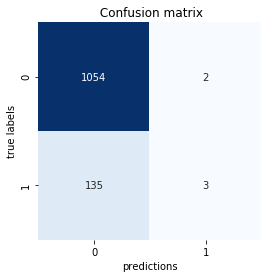

In [62]:
## net = None
rs = None
accuracy_train_epoch_scoring = EpochScoring(scoring='f1', lower_is_better=False, on_train=False)
device = torch.device('cuda:0')
n_blocks = [2, 2, 2]  # number of blocks in the three groups
n_channels = 64
n_epochs = 20
model = NeuralNetClassifier(module=ResNet, criterion=nn.CrossEntropyLoss,
                          module__n_channels= n_channels,
                          module__n_blocks=n_blocks,
                          optimizer=optim.Adam, 
                          optimizer__lr=0.0020242920541016576,
                          #optimizer__weight_decay=0.01,
                          max_epochs=n_epochs, 
                          batch_size=100,
                          iterator_train__shuffle=False,
                          device=device,
                          warm_start=True,#train_split=None,
                          callbacks=[accuracy_epoch_scoring],
                         )
model_name = ResNet.__name__
rs = RandomizedSearchCV(model, parameters, refit=True, 
                        n_iter=10, n_jobs=1,
                       cv=3, scoring='f1')
#rs = GridSearchCV(net, parameters, n_jobs=1, refit=True, 
#                 scoring='f1', cv=3)
rs.fit(x_train, y_train)
pred_test = rs.predict(x_val)  # Predict labels of test data using the trained classifier
accuracy_of_net = plot_confusion_matrix(pred_test, y_val, prefix_information='ResNet',
                          dataset_name='', save_results=False,
                     y_pred_is_predicted_classes=True)

In [63]:
rs.best_params_

{'module__n_blocks': array([2, 8, 3])}

In [42]:
model_dir_path = 'models'
model_filename = "{:s}/{}_ResNet_model_acc-{:2.3f}_{:s}.model".format(
    model_dir_path, 'yahoo_data', accuracy_of_net, strftime("%Y_%m_%d_%H_%M_%S", localtime())
)
pickle.dump(model, open(model_filename, 'wb'))

/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ResNet. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type GroupOfBlocks. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/l7/dev/tools/anaconda3/lib/python3.6/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
